In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
print(tf.__version__)

2.2.0


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [5]:
from pae.model_tf2 import get_prior, get_posterior, get_likelihood

In [22]:
import pae.create_datasets_tf2 as crd

In [23]:
param_file = 'params_fmnist_-1_40_infoGAN_AE_best_params_full_sigma'


In [24]:
# PROJECT_PATH = "../../" 
# PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

In [25]:
params   = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [26]:
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])
if not os.path.isdir(params['data_dir']):
    os.makedirs(params['data_dir'])

In [27]:
params['data_dir']

'/global/cscratch1/sd/vboehm/Datasets'

In [88]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'NF_2')

In [29]:
train_input_fn, eval_input_fn = crd.build_input_fns(params,label=params['class_label'],flatten=False,num_repeat=15)

loading fmnist dataset


In [30]:
tf.reset_default_graph()



traindata     = train_input_fn()
validdata     = eval_input_fn()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)

posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params)

# inspect the model
zt    = posterior(traindata).mean()
recont = likelihood(zt).mean()

zv    = posterior(validdata).mean()
reconv = likelihood(zv).mean()


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variabl

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [32]:
if params['data_set']=='celeba':
    train_size = 162770
    val_size   = 182637-162770 
else:
    train_size = 50000
    val_size   = 10000

In [33]:
print(train_size)

50000


In [34]:
print(train_size//params['batch_size']+1)
enc_path = os.path.join('encoded/',params['data_set'],str(params['latent_size']))
print(os.path.join(params['data_dir'],enc_path))
if not os.path.isdir(os.path.join(params['data_dir'],enc_path)):
    os.makedirs(os.path.join(params['data_dir'],enc_path))

196
/global/cscratch1/sd/vboehm/Datasets/encoded/fmnist/40


In [35]:
try:
    assert(False)
    z_sample = np.load(os.path.join(params['data_dir'],enc_path,'train.npy'))
except:
    z_sample=[]
    for ii in range(train_size//params['batch_size']+1):
        if ii%100==0:
            print(ii)
        z_sample+=[sess.run(zt)]
        
    z_sample = np.asarray(z_sample).reshape((-1,params['latent_size']))
    z_sample = z_sample[0:train_size]
    
    np.save(os.path.join(params['data_dir'],enc_path,'train.npy'),z_sample)

0
100


In [36]:
try:
    assert(False)
    z_sample_valid = np.load(os.path.join(params['data_dir'],enc_path,'valid.npy'))
except:
    z_sample_valid=[]

    for ii in range(val_size//params['batch_size']+1):
        if ii%100==0:
            print(ii)
        z_sample_valid+=[sess.run(zv)]
    z_sample_valid=np.asarray(z_sample_valid).reshape((-1,params['latent_size']))
    z_sample_valid= z_sample_valid[0:val_size]
    np.save(os.path.join(params['data_dir'],enc_path,'valid.npy'),z_sample_valid)

0


In [37]:
np.amax(z_sample)
np.amax(z_sample_valid)

2.332353

In [74]:
nvp_depth    = 16
dims         = np.asarray(16*[40])
nvp_size     = np.arange(nvp_depth)
indices      = np.arange(params['latent_size'])
#permutations = [np.random.permutation(np.arange(params['latent_size'])) for ii in range(nvp_depth)]
#swapping     = np.concatenate((indices[params['latent_size']//2:params['latent_size']],indices[0:params['latent_size']//2]))

In [75]:
def trainable_lu_factorization(
    event_size, batch_shape=(), seed=None, dtype=tf.float32, name=None):
    with tf.name_scope(name or 'trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(
            event_size, dtype_hint=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
            batch_shape, dtype_hint=event_size.dtype, name='batch_shape')
        random_matrix = tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed)
        random_orthonormal = tf.linalg.qr(random_matrix)[0]
        lower_upper, permutation = tf.linalg.lu(random_orthonormal)
        lower_upper = tf.Variable(
            initial_value=lower_upper,
            trainable=True,
            name='lower_upper')
        # Initialize a non-trainable variable for the permutation indices so
        # that its value isn't re-sampled from run-to-run.
        permutation = tf.Variable(
            initial_value=permutation,
            trainable=False,
            name='permutation')
        return lower_upper, permutation


In [81]:
class SplineParams(tf.Module):

    def __init__(self, nunits, nbins=32):
        self._nbins = nbins
        self._nunits= nunits
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def _bin_positions(self, x):
        x = tf.reshape(x, [-1,self._nunits,self._nbins])
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nunits)(net)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nbins)(net)
        net = tf.reshape(net, [-1,self._nunits, self._nbins])
        return tf.math.softmax(net, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

    def _slopes(self, x):
        x = tf.reshape(x, [-1,  self._nunits, ( self._nbins - 1)])
#         net = tf.layers.Dense(self._nunits)(x)
#         net = tf.nn.leaky_relu(net)
#         net = tf.layers.Dense(self._nbins-1)(net)
#         net = tf.reshape(net, [-1,  self._nunits, ( self._nbins - 1)])
        return tf.math.softplus(x) + 1e-2

    def __call__(self, x, nunits):

        bin_positions = self._bin_positions
        if not self._built:
            self._bin_widths  = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='w')
            self._bin_heights = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='h')
            self._knot_slopes = tf.layers.Dense(self._nunits * (self._nbins - 1), activation=self._slopes, name='s')
        self._built = True
        result = tfb.RationalQuadraticSpline(bin_widths=self._bin_widths(x),bin_heights=self._bin_heights(x),knot_slopes=self._knot_slopes(x))
        
        return result

In [82]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
data          = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)


#nvp_size      = [[params['latent_size'],params['latent_size']] for ii in range(nvp_depth)]
#[64,64,64,64,32,32,8,8])#

def get_nvp():
    base_dis          = get_prior(params['latent_size'])
    chain             = []
    reduction         = (params['latent_size']-dims)/params['latent_size']#np.repeat(np.arange(nvp_depth//2)/(nvp_depth//2),2)# np.repeat([0],nvp_depth)#
    current_size      = []
    perms_swap        = []
    perms_rand        = []
    perms_train       = []
    splines           = []
    size              = []
    #current_size      = params['latent_size']
    for i,s in enumerate(nvp_size):
        current_size  = np.int(params['latent_size']*(1-reduction[i]))
        swapping      = np.concatenate((np.arange(current_size//2,current_size),np.arange(0, current_size//2)))
        perms_swap.append(tfb.Permute(permutation=init_once(swapping,name="perm_swap%d"%i)))
        permutation   = np.random.permutation(np.arange(0, current_size))
        perms_rand.append(tfb.Permute(permutation=init_once(permutation,name="perm_rand%d"%i)))
        perms_train.append(tfb.MatvecLU(*trainable_lu_factorization(current_size),validate_args=True, name="perms_train%d"%i))
        splines.append(SplineParams(current_size//2))
        size.append(current_size)
        print(current_size, size)
    
    chain.append(tfb.Scale(3))
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(tfb.Blockwise(bijectors=[perms_train[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        else:
            chain.append(tfb.Blockwise(bijectors=[perms_swap[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        if i<4: 
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,bijector_fn=splines[i])
        if i<12 and i>4:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']]))                 
        else:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']],shift_only=True))  
        bijector2 = tfb.Identity()
        chain.append(tfb.Blockwise(bijectors=[bijector1, bijector2], block_sizes=[size[i],params['latent_size']-size[i]]))
        
    chain.append(tfb.Scale(0.33))
    
    # p(x) is Gaussian, chain: y=g(x)
    nvp=tfd.TransformedDistribution(distribution=tfd.Normal(0,1),bijector=tfb.Chain(chain),name='mynvp', event_shape=(params['latent_size'],))
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)
#nvp_funcs = hub.Module(nvp_path, trainable=True)#
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
loss      = -tf.reduce_mean(nvp_funcs({'z_sample':data,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])

opt_op_nvp= optimizer.minimize(loss)


40 [40]
40 [40, 40]
40 [40, 40, 40]
40 [40, 40, 40, 40]
40 [40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [83]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [84]:
nvp_tloss = []
nvp_vloss = []
ii     = 0

In [89]:
learning_rate = 1e-3
batchsize = 32
epoch = train_size//batchsize
n_epochs = 140
while ii<n_epochs:
    print('epoch ', ii)
    jj = 0
    if ii>50:
        batchsize = 64
    if ii>70:
        batchsize=128
    if ii>80:
        learning_rate = 1e-4
    if ii>100:
        batchsize=64
    epoch = train_size//batchsize
    while jj<epoch:
        noise = np.random.normal(size=(batchsize,params['latent_size']))*2e-2
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:z_sample[jj*batchsize:(jj+1)*batchsize]+noise})
        if jj%200==0:
            np.random.shuffle(z_sample_valid)
            l_v = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample_valid})
            nvp_vloss+=[l_v]
            inds = np.random.randint(low=0, high=train_size, size=1024)
            l_t = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample[inds]})
            nvp_tloss+=[l_t]
            print(l_t, l_v)
#             sample = sess.run(fwd_pass)
#             print(np.amax(sample))
#         if jj==0:
#             nn = np.random.randint(low=0,high=63)
#             plt.scatter(z_sample_valid[:500,nn],z_sample_valid[:500,nn+1],s=1, label='encoded data valid')
#             plt.scatter(z_sample[:500,nn],z_sample[:500,nn+1],s=2, label='encoded data') 
#             plt.scatter(latent_samples[:500,nn],latent_samples[:500,nn+1],s=2, label='RealNVP samples') 
#             plt.show()
        jj+=1
    if ii%5==0 and ii>0:
        nvp_path         = os.path.join(params['module_dir'],'nf1_nepoch%d'%ii)
        nvp_funcs.export(nvp_path,sess)
        
    np.random.shuffle(z_sample)
    ii+=1

epoch  5
-16.579903 -15.795012
-16.44982 -15.89775
-15.90406 -15.4165535
-15.78095 -15.617985
-15.792063 -15.589876
-15.676238 -15.553238
-15.108286 -15.743598
-15.873645 -15.6118355
epoch  6
-16.92483 -15.969525
-16.977194 -16.241276
-15.696778 -15.755103
-16.484192 -16.04593
-16.265911 -15.59925
-15.94081 -15.748608
-17.029778 -16.244951
-16.195276 -15.824841
epoch  7
-16.252367 -16.076073
-15.7068405 -15.9459
-16.89588 -16.144653
-16.838766 -16.382215
-17.542723 -16.51642
-17.04808 -15.943636
-16.765358 -16.293968
-17.13427 -16.426281
epoch  8
-17.537897 -16.27148
-17.133827 -16.454155
-17.785496 -16.198956
-17.354485 -16.560085
-16.83154 -16.536806
-17.622133 -16.586678
-16.577002 -16.503143
-16.85329 -16.284315
epoch  9
-17.895798 -16.422487
-16.225414 -16.496002
-17.245605 -16.607954
-17.687757 -16.678604
-18.030607 -16.482538
-17.265694 -16.481989
-16.7138 -16.63269
-17.018555 -16.474981
epoch  10
-17.305302 -16.604868
-17.52033 -16.490509
-18.204542 -17.091934
-17.323898 -16.48

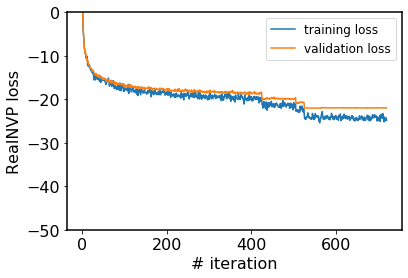

In [91]:
plt.figure()
plt.plot(nvp_tloss,label='training loss')
plt.plot(nvp_vloss,label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.ylim(-50,0)
plt.legend()
plt.savefig(os.path.join(params['plot_dir'],'RealNVP_loss.pdf'),bbox_inches='tight')

In [92]:
sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample_valid})

-21.967426

In [93]:
print(nvp_path)

/global/cscratch1/sd/vboehm/RNF/modules/fmnist/class-1/latent_size40/net_type_infoGAN/loss_AE/best_params_full_sigma/nf1_nepoch135


In [94]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
sigma         = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(params['batch_size'],shape=[])
data          = train_input_fn()
validdata     = eval_input_fn()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
nvp_funcs     = hub.Module(nvp_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

prior         = get_prior(params['latent_size'])
posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params)

# inspect the model
z_      = posterior(validdata).mean()
recon   = likelihood(z_).mean()
prior_sample = prior.sample(sample_size)
x_old   = likelihood(prior_sample).mean()


nvp_sample = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample}, as_dict=True)['fwd_pass']
x_new      = likelihood(nvp_sample).mean()
 
# # ---------------------------end train nvp ----------------- #

# #comment train nvp above section above and uncomment this for loading the trained module

# #

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [95]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [96]:
rec, d = sess.run([recon,validdata])

In [97]:
x_sample = sess.run(x_old)

In [98]:
shape=params['data_shape']

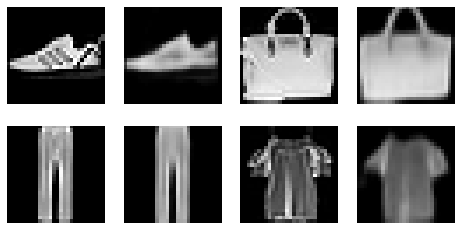

In [99]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(4):
    plt.subplot(2,4,jj)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1
    plt.subplot(2,4,jj)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1


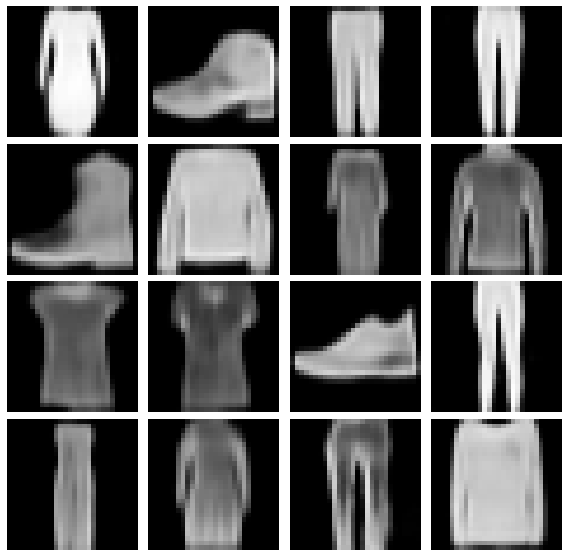

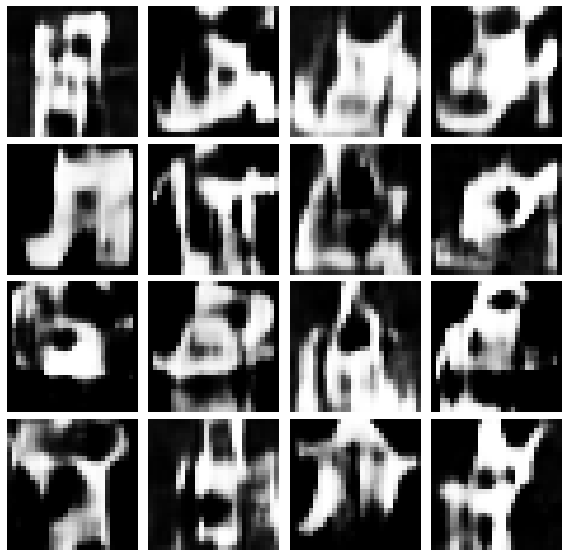

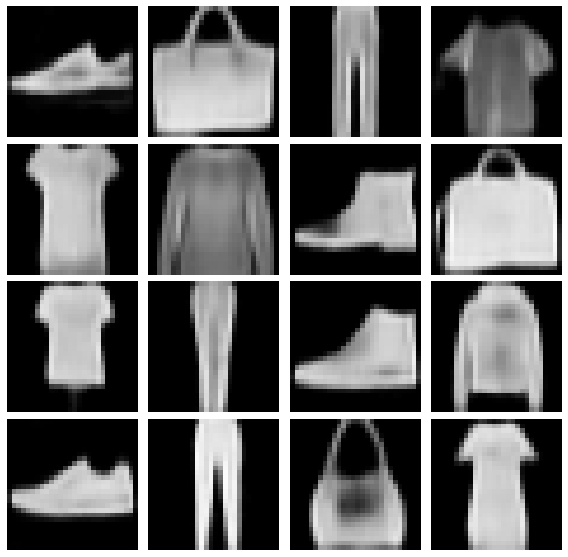

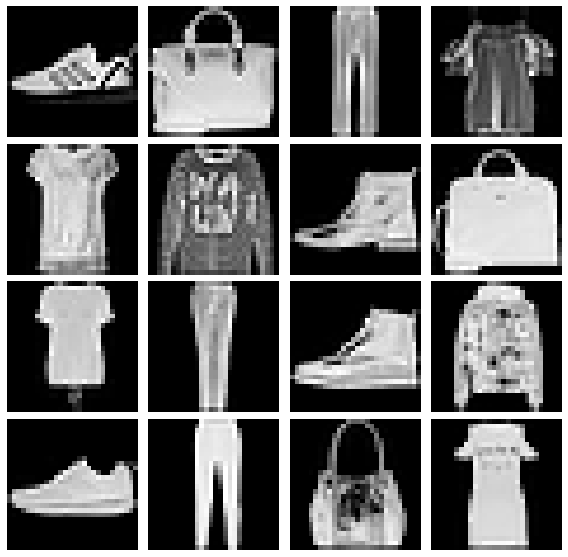

In [103]:
s_no_nvp, s_nvp = sess.run([x_old,x_new])

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((s_nvp[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'NVP_samples.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((s_no_nvp[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'reconstructions.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'inputs.pdf'),bbox_inches='tight')
plt.show()

In [101]:
z_sample_nvp = sess.run(nvp_sample,feed_dict={sample_size:10000})

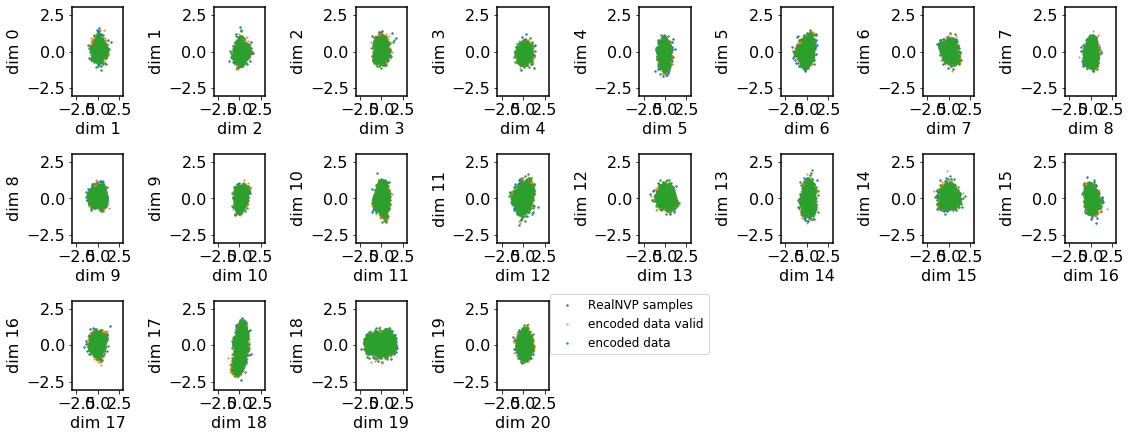

In [102]:
plt.figure(figsize=(16,16))
for nn in range(params['latent_size']-params['latent_size']//2):
    plt.subplot(8,8,nn+1)
    #plt.scatter(prior_s[:5000,nn],prior_s[:5000,nn+1],s=2, label='prior samples') 
    plt.scatter(z_sample_nvp[:5000,nn],z_sample_nvp[:5000,nn+1],s=2, label='RealNVP samples') 
    plt.scatter(z_sample_valid[:5000,nn],z_sample_valid[:5000,nn+1],s=1, label='encoded data valid')
    plt.scatter(z_sample[:5000,nn],z_sample[:5000,nn+1],s=2, label='encoded data')
   
    plt.ylabel('dim %d'%nn)
    plt.xlabel('dim %d'%(nn+1))
    plt.tight_layout()
    plt.xlim(-3,3)
    plt.ylim(-3,3)
plt.legend(loc=(1.02,0.4))
plt.savefig(os.path.join(params['plot_dir'],'latent_space_samples.pdf'),bbox_inches='tight')

In [50]:
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))